In [95]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [96]:
class deepRBF(Kern):
    
    def __init__(self,input_dim,variance1=1.,lengthscale=1.,variance2=1.,active_dims=None):
        super(deepRBF, self).__init__(input_dim, active_dims, 'deep_rbf')
        assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance1 = Param('variance1', variance1)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.link_parameters(self.variance1, self.lengthscale, self.variance2)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        return self.variance2*np.power(1 + tmp2,-0.5)
    
    def Kdiag(self,X):
        return self.variance2*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        dist2 = np.square((X-X2.T)/self.lengthscale)
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1

        dvar2 = np.power(1 + tmp2, -0.5)
        #dl1 = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dvar1 = (-1.)*self.variance2*tmp1*np.power(1+tmp2,-1.5)
        dl = self.variance1*self.variance2*np.exp((-1.)*dist2)*dist2/self.lengthscale*np.power(1+tmp2,-1.5)
        #dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance1.gradient = np.sum(dvar1*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lenthscale2.gradient = np.sum(dl2*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance2.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        return np.sum(dL_dK*dX,1)[:,None]
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


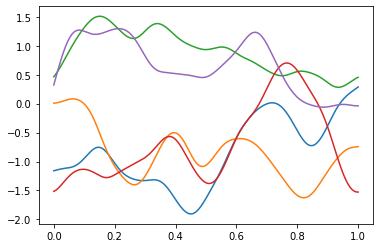

In [236]:
k = deepRBF(input_dim=1,variance1=10,lengthscale=0.5,variance2=1)
xx = np.linspace(0,1,500).reshape(-1,1)
mu = np.zeros(xx.shape[0])

C = k.K(xx,xx)

Z = np.random.multivariate_normal(mu,C,5)

for i in range(5):
    plt.plot(xx[:],Z[i,:])
plt.show()

In [98]:
import pods

In [258]:
data = pods.datasets.olympic_marathon_men()

X_data = data['X']
Y_data = data['Y']

X_clean = np.vstack((X_data[0:2,:],X_data[3:,:]))
Y_clean = np.vstack((Y_data[0:2,:],Y_data[3:,:]))

In [259]:
m1 = GPy.models.GPRegression(data['X'], data['Y'])
m1_clean = GPy.models.GPRegression(X_clean, Y_clean)

In [260]:
m1.kern.lengthscale = 45.
m1.optimize()
#m1.optimize_restarts(num_restarts = 10)

In [261]:
m1_clean.lengthscal1 = 10.
m1_clean.optimize()

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a23903dd8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a23903d30>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a23911518>]}

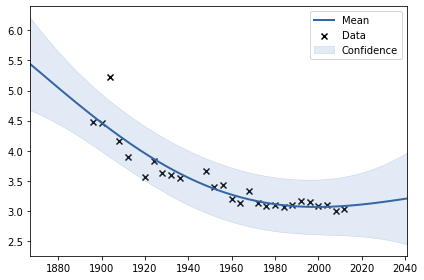

In [262]:
m1.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a23a47048>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a23903f98>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a23a477b8>]}

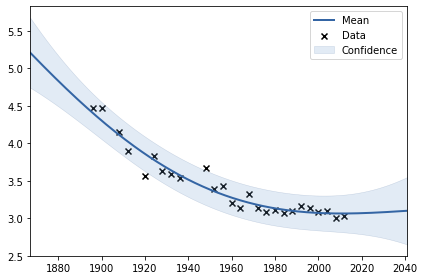

In [263]:
m1_clean.plot()

In [275]:
kern_test = deepRBF(input_dim=1,variance1=0.1,lengthscale=42,variance2=1.5)

In [276]:
m2 = GPy.models.GPRegression(data['X'], data['Y'], kern_test)
#m2.kern.variance2 = 0.1

In [277]:
m2.optimize('bfgs',max_iters=2000)
#m2.optimize_restarts(num_restarts = 5)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a23e92ac8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a2373ec88>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a23f34ac8>]}

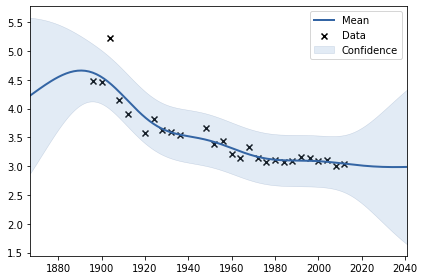

In [278]:
m2.plot()

In [279]:
print(m2)


Name : GP regression
Objective : 8.735560637579832
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  deep_rbf.variance1       |    0.472706025018346  |               |        
  deep_rbf.lengtscale      |    42.00372859653268  |               |        
  deep_rbf.variance2       |    2.905463273366636  |               |        
  Gaussian_noise.variance  |  0.04394812917996934  |      +ve      |        


In [280]:
print(m1)


Name : GP regression
Objective : 6.947137914569213
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   25.401464946593556  |      +ve      |        
  rbf.lengthscale          |   152.04729323937184  |      +ve      |        
  Gaussian_noise.variance  |  0.04850680410222106  |      +ve      |        


In [281]:
print(m1_clean)


Name : GP regression
Objective : -8.641889337869937
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    27.848243512500694  |      +ve      |        
  rbf.lengthscale          |    169.34465727481756  |      +ve      |        
  Gaussian_noise.variance  |  0.012602111071108235  |      +ve      |        
